In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K

PATH = "../input/cell-images-for-detecting-malaria/cell_images/cell_images/"
print(os.listdir(PATH))

['Parasitized', 'Uninfected']


Using TensorFlow backend.


 * https://github.com/keras-team/keras/issues/5400
 * https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras

In [ ]:
def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
      y_pred = y_pred[:,1:2]
      y_true = y_true[:,1:2]
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#you can use it as following
#model.compile(loss='binary_crossentropy',
              #optimizer= "adam",
              #metrics=[precision,recall, f1])

In [2]:
# all image path of parasitized
paths_para=glob.glob(os.path.join(PATH,'Parasitized','*.png'))
paths_uninf=glob.glob(os.path.join(PATH,'Uninfected','*.png'))
len(paths_para), len(paths_uninf)

(13779, 13779)

In [3]:
# show one
path=paths_para[0]
img=cv2.imread(path) # cv2 stores image in BGR format
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # transforming to RGB format
img.shape

(130, 118, 3)

In [4]:
# helper to get images
def get_data(path, resize_dim=200):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_rz=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
    return img_rz

## Get the data

In [5]:
parasite_images=np.array([get_data(path) for path in paths_para])
parasite_images.shape

(13779, 200, 200, 3)

In [6]:
uninf_images=np.array([get_data(path) for path in paths_uninf])
uninf_images.shape

(13779, 200, 200, 3)

## Make labels

In [7]:
para_label = np.array([1 for _ in range(len(parasite_images))])
uninf_label = np.array([0 for _ in range(len(uninf_images))])

para_label.shape, uninf_label.shape

((13779,), (13779,))

## Data set initialize

In [8]:
x_all = np.concatenate((parasite_images, uninf_images), axis=0)
y_all = np.concatenate((para_label, uninf_label), axis=0)
print(x_all.shape, y_all.shape)

del parasite_images 
del uninf_images

#train = shuffle(train, random_state=123)

(27558, 200, 200, 3) (27558,)


## Show an image

Index number: 8536
Label: 1


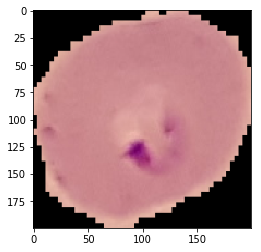

In [9]:
idx = random.randint(0, len(x_all))
print("Index number: {}".format(idx))
print("Label: {}".format(y_all[idx]))
plt.imshow(x_all[idx])

## Show many images

In [ ]:
plt.figure(figsize=(20,20))
columns = 5

lower = 0
upper = 30 

for i in range(upper):
    ax = plt.subplot(upper / columns + 1, columns, i + 1)
    idx = random.randint(0, len(x_all))
    ax.set_title(y_all[idx])
    plt.imshow(x_all[idx], cmap='gray') # binary
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

## Make training and testing sets

In [10]:
indices=list(range(len(x_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.90)
# train data
input_features=x_all[indices[:ind]] 
labels=y_all[indices[:ind]]
# validation data
x_test=x_all[indices[-(len(indices)-ind):]] 
y_test=y_all[indices[-(len(indices)-ind):]]

In [11]:
print(x_all.shape, y_all.shape)

(27558, 200, 200, 3) (27558,)


## Define network

In [ ]:
def first():
    input_shape = (96, 96, 3)
    model = Sequential()
    model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=input_shape, activation='relu'))
    model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0), #RMSprop(lr=0.0001) #deafult LR=0.001
                metrics=['accuracy'])
                # metrics=[mcor,recall, f1]
    return model

In [ ]:
model=first()
model.summary()

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.1, random_state=1)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(24802, 200, 200, 3) (2756, 200, 200, 3) (24802,) (2756,)


In [ ]:
model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          validation_data=(x_val, y_val))

print("Done training...")

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
'''
80-10% 10% split -> 
Test loss: 0.12058413857580616
Test accuracy: 0.967343976777939
'''

# Transfer Learning

In [14]:
# model with ALL layers frozen, except for the SOFTMAX layer
def vgg16():
    base_model = VGG16(weights='../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',include_top=False,pooling='avg',input_shape=(200, 200, 3))
    base_model.trainable = False
    X = base_model.output
    X.trainable = False
    # softmax layer
    predictions = Dense(2, activation='softmax')(X)
    
    # magical line of freezing layers
    for layer in base_model.layers[:-3]:
        layer.trainable=False

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy']) ##metrics=[precision,recall, f1])
    return model

model=vgg16()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [15]:
# check input
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(24802, 200, 200, 3) (24802,) (2756, 200, 200, 3) (2756,)


In [16]:
# one hot encoded vectors
num_classes = 2

y_train = np_utils.to_categorical(y_train,num_classes)
y_val = np_utils.to_categorical(y_val,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
print(y_train.shape, y_val.shape, y_test.shape)

(24802, 2) (2756, 2) (2756, 2)


In [17]:
# check input
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(24802, 200, 200, 3) (24802, 2) (2756, 200, 200, 3) (2756, 2) (2756, 200, 200, 3) (2756, 2)


In [18]:
model=vgg16()
path_model='vgg16.h5'  

# set the learning rate
K.set_value(model.optimizer.lr,1e-2) 

h=model.fit(x=x_train,     
            y=y_train, 
            batch_size=32, 
            epochs=30, 
            verbose=1, 
            validation_data=(x_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )


Train on 24802 samples, validate on 2756 samples
Epoch 1/30
24802/24802 [==============================] - 237s 10ms/step - loss: 0.2905 - acc: 0.9066 - val_loss: 0.1513 - val_acc: 0.9510
Epoch 2/30
24802/24802 [==============================] - 230s 9ms/step - loss: 0.1402 - acc: 0.9533 - val_loss: 0.1366 - val_acc: 0.9510
Epoch 3/30
24802/24802 [==============================] - 231s 9ms/step - loss: 0.1218 - acc: 0.9583 - val_loss: 0.1462 - val_acc: 0.9517
Epoch 4/30
24802/24802 [==============================] - 230s 9ms/step - loss: 0.1092 - acc: 0.9622 - val_loss: 0.1322 - val_acc: 0.9539
Epoch 5/30
24802/24802 [==============================] - 230s 9ms/step - loss: 0.1001 - acc: 0.9648 - val_loss: 0.4323 - val_acc: 0.8374
Epoch 6/30
24802/24802 [==============================] - 230s 9ms/step - loss: 0.0924 - acc: 0.9677 - val_loss: 0.1306 - val_acc: 0.9586
Epoch 7/30
24802/24802 [==============================] - 230s 9ms/step - loss: 0.0855 - acc: 0.9698 - val_loss: 0.1208 - 

In [19]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.036485219879835544
Test accuracy: 0.9887518142235123


In [22]:
def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Training loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid()
    plt.show()
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid()
    plt.show()


In [ ]:
plot_loss_accu(h)